<a href="https://colab.research.google.com/github/BenGardiner18/Fran-ois-Chollet-Deep-Learning-with-Python/blob/main/ch8_cats_v_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting dataset from kaggle into colab filesystem

In [2]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bengardiner","key":"60a15c5712225f050e394fddea94cbbc"}'}

In [3]:
# connecting to kaggle though command line
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# downloading data from kaggle
!kaggle competitions download -c dogs-vs-cats

# uncompressing zipped folder
!unzip -qq dogs-vs-cats.zip

# unzipping training file
!unzip -qq train.zip

100% 811M/812M [00:04<00:00, 258MB/s]
100% 812M/812M [00:04<00:00, 195MB/s]


In [4]:
import os, shutil, pathlib
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index): 
  for category in ("cat", "dog"):
      dir = new_base_dir / subset_name / category
      os.makedirs(dir)
      fnames = [f"{category}.{i}.jpg"
        for i in range(start_index, end_index)] 
      for fname in fnames:
        shutil.copyfile(src=original_dir / fname,
                        dst=dir / fname)
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

# Building the model

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x) 
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [8]:
model.compile(
  loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"]
  )

# Preprocessing data 


In [9]:
from tensorflow.keras.utils import image_dataset_from_directory


# size (180,180)
# batches (32)
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [10]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch.keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 [==============================] - 17s 83ms/step - loss: 0.7085 - accuracy: 0.5100 - val_loss: 0.6917 - val_accuracy: 0.5120
Epoch 2/30
63/63 [==============================] - 5s 77ms/step - loss: 0.7173 - accuracy: 0.5490 - val_loss: 0.6687 - val_accuracy: 0.5730
Epoch 3/30
63/63 [==============================] - 5s 71ms/step - loss: 0.6781 - accuracy: 0.5755 - val_loss: 0.6598 - val_accuracy: 0.5960
Epoch 4/30
63/63 [==============================] - 5s 73ms/step - loss: 0.6466 - accuracy: 0.6580 - val_loss: 0.6736 - val_accuracy: 0.6010
Epoch 5/30
63/63 [==============================] - 5s 71ms/step - loss: 0.6169 - accuracy: 0.6715 - val_loss: 0.6218 - val_accuracy: 0.6670
Epoch 6/30
63/63 [==============================] - 5s 71ms/step - loss: 0.5952 - accuracy: 0.7175 - val_loss: 0.5859 - val_accuracy: 0.6940
Epoch 7/30
63/63 [==============================] - 5s 71ms/step - loss: 0.5416 - accuracy: 0.7405 - val_loss: 0.6494 - val_accuracy: 0.6400
Epoch 8/30
6

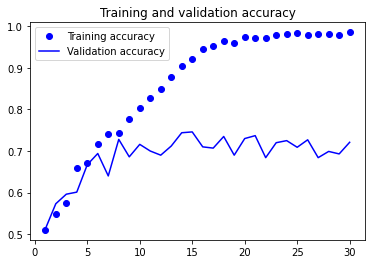

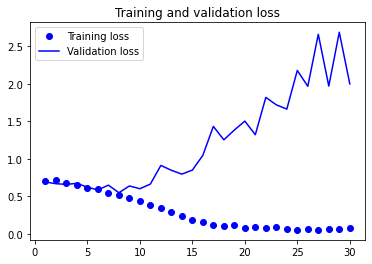

In [12]:
import matplotlib.pyplot as plt

# display results
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# accuracy
plt.plot(epochs, accuracy, "bo", label="Training accuracy") 
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy") 
plt.title("Training and validation accuracy")
plt.legend()

# loss
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss") 
plt.plot(epochs, val_loss, "b", label="Validation loss") 
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [13]:
test_model = keras.models.load_model("convnet_from_scratch.keras") 
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 38ms/step - loss: 0.5851 - accuracy: 0.7215
Test accuracy: 0.721


# Our model was GOOD lets make it GREAT

# Data augmentation

In [14]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

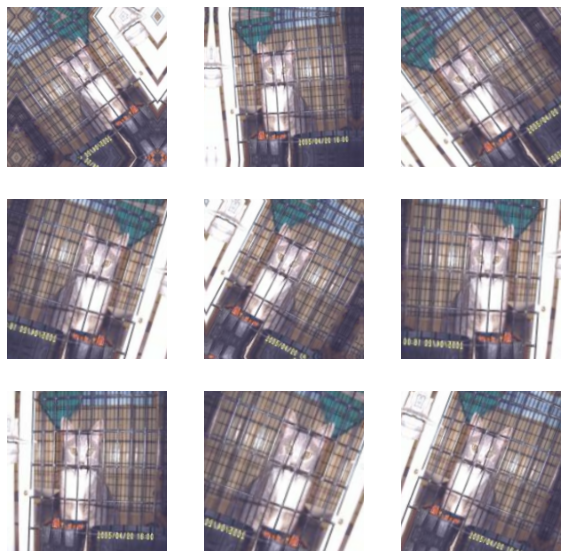

In [15]:
# displaying what data augmentation is doing to a sample image
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1) 
    plt.imshow(augmented_images[0].numpy().astype("uint8")) 
    plt.axis("off")


# Dropout layer

In [16]:
# creating a new model with a dropout layer
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x) # DROPOUT LAYER 
outputs = layers.Dense(1, activation="sigmoid")(x) 
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 10s 132ms/step - loss: 0.7758 - accuracy: 0.5070 - val_loss: 0.6927 - val_accuracy: 0.5060
Epoch 2/100
63/63 [==============================] - 6s 97ms/step - loss: 0.6985 - accuracy: 0.5205 - val_loss: 0.6893 - val_accuracy: 0.5360
Epoch 3/100
63/63 [==============================] - 6s 95ms/step - loss: 0.6924 - accuracy: 0.5540 - val_loss: 0.6802 - val_accuracy: 0.5550
Epoch 4/100
63/63 [==============================] - 6s 96ms/step - loss: 0.6629 - accuracy: 0.6240 - val_loss: 0.7052 - val_accuracy: 0.5870
Epoch 5/100
63/63 [==============================] - 6s 97ms/step - loss: 0.6552 - accuracy: 0.6310 - val_loss: 0.6762 - val_accuracy: 0.5940
Epoch 6/100
63/63 [==============================] - 6s 97ms/step - loss: 0.6456 - accuracy: 0.6350 - val_loss: 0.6319 - val_accuracy: 0.6350
Epoch 7/100
63/63 [==============================] - 6s 97ms/step - loss: 0.6318 - accuracy: 0.6585 - val_loss: 0.6936 - val_accuracy: 0.5520
Epoc

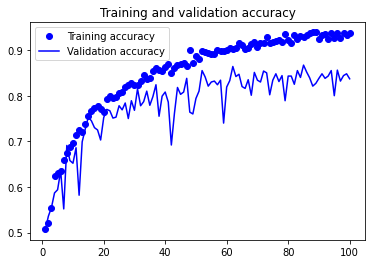

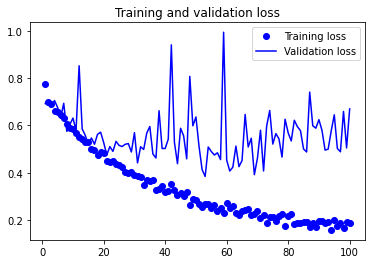

In [18]:
# display results
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# accuracy
plt.plot(epochs, accuracy, "bo", label="Training accuracy") 
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy") 
plt.title("Training and validation accuracy")
plt.legend()

# loss
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss") 
plt.plot(epochs, val_loss, "b", label="Validation loss") 
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [19]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 42ms/step - loss: 0.4536 - accuracy: 0.8155
Test accuracy: 0.816


# Pretrained Models

In [20]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False, # top refers to end of network (classifier)
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [21]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [22]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [23]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
] )
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [24]:

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [26]:
history = model.fit(
          train_dataset,
          epochs=50,
          validation_data=validation_dataset,
          callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 19s 251ms/step - loss: 18.5805 - accuracy: 0.8935 - val_loss: 11.3861 - val_accuracy: 0.9500
Epoch 2/50
63/63 [==============================] - 14s 220ms/step - loss: 7.8603 - accuracy: 0.9445 - val_loss: 5.8632 - val_accuracy: 0.9610
Epoch 3/50
63/63 [==============================] - 13s 197ms/step - loss: 7.0343 - accuracy: 0.9550 - val_loss: 8.1651 - val_accuracy: 0.9600
Epoch 4/50
63/63 [==============================] - 14s 212ms/step - loss: 5.0333 - accuracy: 0.9605 - val_loss: 3.8472 - val_accuracy: 0.9690
Epoch 5/50
63/63 [==============================] - 13s 206ms/step - loss: 2.9354 - accuracy: 0.9730 - val_loss: 4.5443 - val_accuracy: 0.9680
Epoch 6/50
63/63 [==============================] - 13s 204ms/step - loss: 3.9449 - accuracy: 0.9600 - val_loss: 3.8384 - val_accuracy: 0.9770
Epoch 7/50
63/63 [==============================] - 13s 201ms/step - loss: 3.7976 - accuracy: 0.9705 - val_loss: 7.1386 - val_accuracy: 0.96

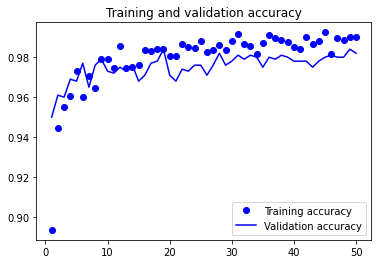

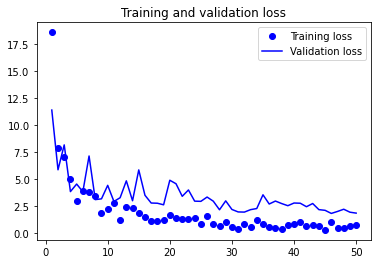

63/63 [==============================] - 8s 111ms/step - loss: 2.2361 - accuracy: 0.9735
Test accuracy: 0.974


In [27]:
# display results
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# accuracy
plt.plot(epochs, accuracy, "bo", label="Training accuracy") 
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy") 
plt.title("Training and validation accuracy")
plt.legend()

# loss
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss") 
plt.plot(epochs, val_loss, "b", label="Validation loss") 
plt.title("Training and validation loss")
plt.legend()
plt.show()

# print evaluation
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

In [28]:
# fine tuning our model

conv_base.trainable = True
for layer in conv_base.layers[:-4]: # freezing everything but the (4th to last - last)
    layer.trainable = False

In [29]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 16s 227ms/step - loss: 0.5174 - accuracy: 0.9885 - val_loss: 1.7771 - val_accuracy: 0.9780
Epoch 2/30
63/63 [==============================] - 15s 227ms/step - loss: 0.3738 - accuracy: 0.9920 - val_loss: 1.7398 - val_accuracy: 0.9790
Epoch 3/30
63/63 [==============================] - 14s 219ms/step - loss: 0.2236 - accuracy: 0.9910 - val_loss: 2.4601 - val_accuracy: 0.9730
Epoch 4/30
63/63 [==============================] - 14s 219ms/step - loss: 0.2786 - accuracy: 0.9915 - val_loss: 1.8685 - val_accuracy: 0.9770
Epoch 5/30
63/63 [==============================] - 14s 217ms/step - loss: 0.3269 - accuracy: 0.9900 - val_loss: 1.9600 - val_accuracy: 0.9780
Epoch 6/30
63/63 [==============================] - 14s 226ms/step - loss: 0.1509 - accuracy: 0.9945 - val_loss: 1.7519 - val_accuracy: 0.9780
Epoch 7/30
63/63 [==============================] - 14s 223ms/step - loss: 0.3063 - accuracy: 0.9930 - val_loss: 1.7079 - val_accuracy: 0.9800

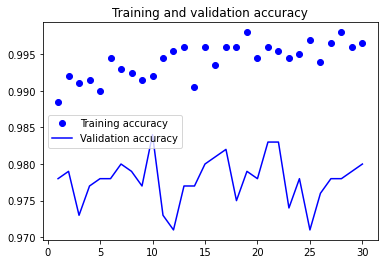

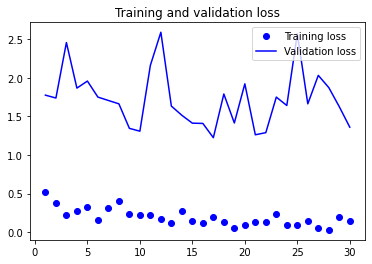

63/63 [==============================] - 8s 111ms/step - loss: 1.7772 - accuracy: 0.9760
Test accuracy: 0.976


In [30]:
# display results
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# accuracy
plt.plot(epochs, accuracy, "bo", label="Training accuracy") 
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy") 
plt.title("Training and validation accuracy")
plt.legend()

# loss
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss") 
plt.plot(epochs, val_loss, "b", label="Validation loss") 
plt.title("Training and validation loss")
plt.legend()
plt.show()

# model evaluation
model = keras.models.load_model("fine_tuning.keras") 
test_loss, test_acc = model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")